In [ ]:
!pip install neuralforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.8/141.8 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATSx
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, MSE, MAE
from neuralforecast.tsdataset import TimeSeriesDataset, TimeSeriesLoader
from numpy.random import seed
from random import randrange
from neuralforecast.losses.numpy import rmse, mape
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
df = pd.read_excel("/content/drive/MyDrive/Hugo's Portfolio/Introducing NBEATSx to Realized Volatility Forecasting (Research)/NASDAQ Realized Volatility (NBEATSx).xlsx",index_col='Date',parse_dates=True)



In [ ]:
df.reset_index(inplace=True)
df.rename(columns={'Date':'ds'}, inplace=True)
df.rename(columns={'Realised':'y'}, inplace=True)
train = df.iloc[:int(len(df['y'])*0.7)]
test = df.iloc[int(len(df['y'])*0.7)]
validation_length=int(len(df['y'])*0.7)-int(len(df['y'])*0.6)

In [ ]:
n_inputs = [21,63,84,126,189,252]
mlp_units = [[[712, 712], [712, 712]],[[512, 512], [512, 512]],[[250, 250], [250, 250]],[[100, 100], [100, 100]]]
epochs = [100,150,200]
learning_rate=[0.05,0.005,0.0005,0.0001]
num_lr_decays=[10,5,3,5]
dropouts=[0,0.2,0.4]
scaler_type=["robust","standard",'minmax']
stack_types=[['identity','identity'],['trend','identity'],['seasonality','identity'],['trend','seasonality']]
n_harmonics=[0,0,1,1]
n_polynomials=[0,1,0,1]
losses=[MSE(),MAE(),MQLoss(level=[80, 90]),DistributionLoss(distribution='StudentT', level=[80, 90])]
RMSE = []
Accuracy = []

# Hyperparameter Search

In [ ]:
for m in range (5):
  i=randrange(6)
  h=randrange(4)
  k=randrange(3)
  l=randrange(4)
  m=randrange(4)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=1, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=[1, 1],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length,step_size=1)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true)
  Accuracy=(1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {losses[m]} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]}")
  print(f"RMSE: {RMSE} | Accuracy: {Accuracy}")

INFO:lightning_fabric.utilities.seed:Global seed set to 4209457


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 122827228


Epoch: 100 | Inputs: 252 | MLP units: [[512, 512], [512, 512]] | Loss: MSE() | Scaler Type: standard
Stack Types: ['trend', 'identity'] | Learning Rate: 0.005
RMSE: 0.002149579100711041 | Accuracy: 70.6602792831088


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 101610445


Epoch: 100 | Inputs: 126 | MLP units: [[250, 250], [250, 250]] | Loss: MSE() | Scaler Type: standard
Stack Types: ['trend', 'identity'] | Learning Rate: 0.05
RMSE: 0.3250006855745935 | Accuracy: -4674.589231894932


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 44702562


Epoch: 200 | Inputs: 252 | MLP units: [[100, 100], [100, 100]] | Loss: MQLoss() | Scaler Type: robust
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0005
RMSE: 0.0022752005604976485 | Accuracy: 69.96384386496246


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 60630985


Epoch: 150 | Inputs: 189 | MLP units: [[100, 100], [100, 100]] | Loss: MSE() | Scaler Type: standard
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0001
RMSE: 0.0021140622749153035 | Accuracy: 69.92015572119017


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 200 | Inputs: 84 | MLP units: [[100, 100], [100, 100]] | Loss: MAE() | Scaler Type: standard
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.05
RMSE: 0.0020976821974675445 | Accuracy: 70.13957098719241


In [ ]:
for m in range (5):
  i=randrange(6)
  h=randrange(4)
  k=randrange(3)
  l=randrange(4)
  m=randrange(4)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=1, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=[1, 1],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length,step_size=1)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true)
  Accuracy=(1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {losses[m]} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]}")
  print(f"RMSE: {RMSE} | Accuracy: {Accuracy}")

INFO:lightning_fabric.utilities.seed:Global seed set to 100232414


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 8911557


Epoch: 150 | Inputs: 189 | MLP units: [[250, 250], [250, 250]] | Loss: MAE() | Scaler Type: standard
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0005
RMSE: 0.0027170214311804794 | Accuracy: 64.97866312854852


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 26788604


Epoch: 200 | Inputs: 252 | MLP units: [[712, 712], [712, 712]] | Loss: MQLoss() | Scaler Type: standard
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0005
RMSE: 0.002992564750305203 | Accuracy: 60.87445894967042


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 46422078


Epoch: 100 | Inputs: 189 | MLP units: [[250, 250], [250, 250]] | Loss: MAE() | Scaler Type: minmax
Stack Types: ['trend', 'identity'] | Learning Rate: 0.05
RMSE: 2.5125149562445594 | Accuracy: -37894.661495102366


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 105746955


Epoch: 150 | Inputs: 252 | MLP units: [[512, 512], [512, 512]] | Loss: DistributionLoss() | Scaler Type: standard
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.005
RMSE: 0.0024103009714653307 | Accuracy: 63.57284990288894


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 200 | Inputs: 84 | MLP units: [[512, 512], [512, 512]] | Loss: MQLoss() | Scaler Type: standard
Stack Types: ['trend', 'identity'] | Learning Rate: 0.005
RMSE: 0.0030534339279935686 | Accuracy: 61.626849734258094


In [ ]:
for m in range (5):
  i=randrange(6)
  h=randrange(4)
  k=randrange(3)
  l=randrange(4)
  m=randrange(4)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=1, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=[1, 1],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length,step_size=1)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true)
  Accuracy=(1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {losses[m]} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]}")
  print(f"RMSE: {RMSE} | Accuracy: {Accuracy}")

INFO:lightning_fabric.utilities.seed:Global seed set to 56804546


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 16027455


Epoch: 200 | Inputs: 21 | MLP units: [[100, 100], [100, 100]] | Loss: MSE() | Scaler Type: robust
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0005
RMSE: 0.002936258105772296 | Accuracy: 59.13054973212448


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 112265396


Epoch: 150 | Inputs: 189 | MLP units: [[512, 512], [512, 512]] | Loss: DistributionLoss() | Scaler Type: standard
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.005
RMSE: 0.0025707104717989765 | Accuracy: 62.28325866183611


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 77100669


Epoch: 150 | Inputs: 126 | MLP units: [[712, 712], [712, 712]] | Loss: MQLoss() | Scaler Type: robust
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.005
RMSE: 0.002799611262907603 | Accuracy: 66.542981308414


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 5559236


Epoch: 150 | Inputs: 126 | MLP units: [[100, 100], [100, 100]] | Loss: MQLoss() | Scaler Type: robust
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0001
RMSE: 0.0021641484264951485 | Accuracy: 70.29179160043712


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 150 | Inputs: 63 | MLP units: [[100, 100], [100, 100]] | Loss: MAE() | Scaler Type: robust
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0001
RMSE: 0.00208053588312411 | Accuracy: 71.08651966429724


In [ ]:
for m in range (5):
  i=randrange(6)
  h=randrange(4)
  k=randrange(3)
  l=randrange(4)
  m=randrange(4)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=1, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=[1, 1],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length,step_size=1)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true)
  Accuracy=(1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {losses[m]} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]}")
  print(f"RMSE: {RMSE} | Accuracy: {Accuracy}")

INFO:lightning_fabric.utilities.seed:Global seed set to 17821126


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 80227865


Epoch: 200 | Inputs: 21 | MLP units: [[512, 512], [512, 512]] | Loss: MQLoss() | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0001
RMSE: 0.002013781364951 | Accuracy: 72.37892738925724


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 117231767


Epoch: 100 | Inputs: 252 | MLP units: [[100, 100], [100, 100]] | Loss: MQLoss() | Scaler Type: minmax
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.005
RMSE: 0.0023854828236864072 | Accuracy: 68.6686133893642


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 77835615


Epoch: 200 | Inputs: 126 | MLP units: [[712, 712], [712, 712]] | Loss: MAE() | Scaler Type: robust
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0001
RMSE: 0.002509568389641478 | Accuracy: 65.94831480696696


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 75798991


Epoch: 100 | Inputs: 126 | MLP units: [[250, 250], [250, 250]] | Loss: MQLoss() | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 0.05
RMSE: 0.9264290687949231 | Accuracy: -11563.39601232103


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 200 | Inputs: 252 | MLP units: [[100, 100], [100, 100]] | Loss: MQLoss() | Scaler Type: standard
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.05
RMSE: 0.005953456069123008 | Accuracy: 10.56283535632212


Epoch: 200 | Inputs: 21 | MLP units: [[512, 512], [512, 512]] | Loss: MQLoss() | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0001

# H=1 Forecasts

In [ ]:
df=df[:len(df["y"])-1]

In [ ]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]

In [ ]:
test_length=len(df["y"])-int(len(df['y'])*0.7)

In [ ]:
model = NBEATSx(h=1, input_size=21,
                loss=MQLoss(level=[90]),
                scaler_type='minmax',
                learning_rate= 0.0001,
                stack_types=['identity','identity'],
                n_blocks=[1,1],
                mlp_units= [[512, 512], [512, 512]],
                windows_batch_size=60,
                num_lr_decays=5,
                val_check_steps=100,
                n_harmonics=0, n_polynomials=0,
                hist_exog_list=['VIX'],
                max_steps=200,
                early_stop_patience_steps=1,
                random_seed=randrange(129228148)
                )
fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
forecasts = fcst.cross_validation(df=df,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=test_length,step_size=1)
forecasts = forecasts.dropna()
if "NBEATSx-median" not in list(forecasts.columns.values):
  Y_hat=forecasts["NBEATSx"].values
else:
  Y_hat=forecasts["NBEATSx-median"].values
Y_true=forecasts["y"].values
RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 80732464


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
Accuracy

[62.90177460448652,
 62.96306785881644,
 62.68543867134036,
 62.226534877190346,
 62.42571504945123,
 62.944641784128876,
 61.276365714736784,
 62.48032723466588,
 63.52953081169327,
 62.979966874826,
 63.4075316504027,
 61.48876663113268,
 62.07067789016193,
 63.169504974866854,
 63.63855309862549]

In [ ]:
RMSE

[0.003479228827264976,
 0.0035142825426138177,
 0.0035033398968454025,
 0.003513788684834837,
 0.0035389143099392906,
 0.003549010828549323,
 0.0035306600151611676,
 0.0035254427090942544,
 0.003495834857682245,
 0.0035289192651190987,
 0.0034610319970548717,
 0.003554123876064139,
 0.003550223778063494,
 0.003510220214816488,
 0.0034958127666462604]

In [ ]:
Quasilikelihood

[0.1009244326111866,
 0.10189517659458075,
 0.09942176492033437,
 0.09916761639168213,
 0.10198360380580937,
 0.10503704959701234,
 0.09589036669410374,
 0.09822487028414081,
 0.10424099766673114,
 0.10247408130886258,
 0.09628086095754916,
 0.10132941690176421,
 0.10060650090955256,
 0.10517832950435282,
 0.1037663042820685]

Text(0, 0.5, 'NASDAQ Realized Volatility')

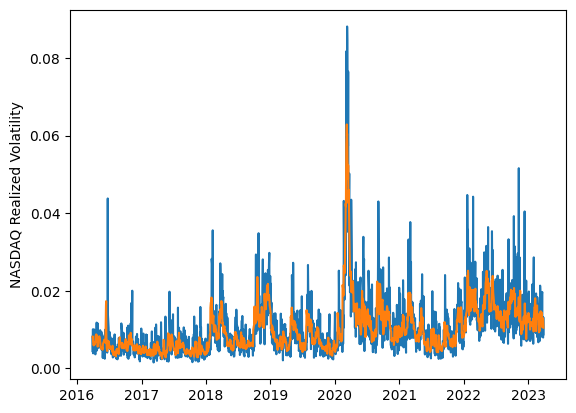

In [ ]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("NASDAQ Realized Volatility")

# H=3 Forecasts

In [ ]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]

In [ ]:
model = NBEATSx(h=3, input_size=21,
                loss=MQLoss(level=[90]),
                scaler_type='minmax',
                learning_rate= 0.0001,
                stack_types=['identity','identity'],
                n_blocks=[1,1],
                mlp_units= [[512, 512], [512, 512]],
                windows_batch_size=60,
                num_lr_decays=5,
                val_check_steps=100,
                n_harmonics=0, n_polynomials=0,
                hist_exog_list=['VIX'],
                max_steps=200,
                early_stop_patience_steps=1,
                random_seed=randrange(129228148)
                )
fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
forecasts = fcst.cross_validation(df=df,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=test_length,step_size=3)
forecasts = forecasts.dropna()
if "NBEATSx-median" not in list(forecasts.columns.values):
  Y_hat=forecasts["NBEATSx"].values
else:
  Y_hat=forecasts["NBEATSx-median"].values
Y_true=forecasts["y"].values
RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 89476007


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
Accuracy

[64.23751110095759,
 64.70379165530406,
 64.41901306224878,
 64.08324869078317,
 64.75715973118584,
 63.813212930067834,
 64.7291462706047,
 63.27418976539265,
 64.70271972649152,
 64.7239729483926,
 64.63266119274367,
 64.31522394809029,
 64.61953293405523,
 63.58600858270871,
 64.88644156654694]

In [ ]:
RMSE

[0.0034126749356498914,
 0.0033942538826932534,
 0.0034009754683280487,
 0.003435356501855502,
 0.003396524005625698,
 0.0034366977289813356,
 0.0033969189223572362,
 0.003426003544281087,
 0.0034133013524593795,
 0.0033943174773060727,
 0.0034258415288244185,
 0.0033964206346487782,
 0.0034066962722737893,
 0.003426452963091824,
 0.0034136618631554682]

In [ ]:
Quasilikelihood

[0.0896533333710633,
 0.08812578381481474,
 0.09016349260587275,
 0.0906282425981159,
 0.09006506258139448,
 0.09023518178755303,
 0.08902153396606728,
 0.08750930441808376,
 0.09140944279089967,
 0.09154783972859534,
 0.09242526767569759,
 0.08817241818991452,
 0.08978892027572202,
 0.08942438216482101,
 0.09110806993481953]

Text(0, 0.5, 'NASDAQ Realized Volatility')

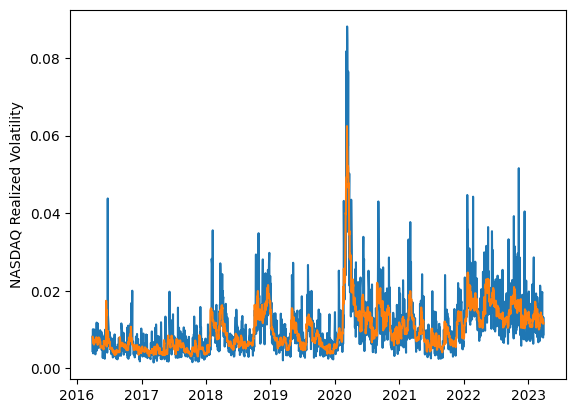

In [ ]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("NASDAQ Realized Volatility")

# H=5 Forecasts

In [ ]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]

In [ ]:
model = NBEATSx(h=5, input_size=21,
                loss=MQLoss(level=[90]),
                scaler_type='minmax',
                learning_rate= 0.0001,
                stack_types=['identity','identity'],
                n_blocks=[1,1],
                mlp_units= [[512, 512], [512, 512]],
                windows_batch_size=60,
                num_lr_decays=5,
                val_check_steps=100,
                n_harmonics=0, n_polynomials=0,
                hist_exog_list=['VIX'],
                max_steps=200,
                early_stop_patience_steps=1,
                random_seed=randrange(129228148)
                )
fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
forecasts = fcst.cross_validation(df=df,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=test_length,step_size=5)
forecasts = forecasts.dropna()
if "NBEATSx-median" not in list(forecasts.columns.values):
  Y_hat=forecasts["NBEATSx"].values
else:
  Y_hat=forecasts["NBEATSx-median"].values
Y_true=forecasts["y"].values
RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 61581971


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
RMSE

[0.003495774020831819,
 0.0034882809137644984,
 0.0034765988068126397,
 0.0034329410669723883,
 0.0034089679106845197,
 0.003496059469998788,
 0.003490597411721704,
 0.003465812826929921,
 0.003432359804760241,
 0.003416407855090251,
 0.003441069983639977,
 0.0034186657087228274,
 0.003452834485894627,
 0.0034162124613095566,
 0.003442649137572511]

In [ ]:
Accuracy

[64.09714892235736,
 64.85484570445009,
 64.22875356774101,
 65.30472287014419,
 64.29988614439502,
 63.9864487105695,
 64.6470095842734,
 64.12338548572882,
 64.29130985862635,
 64.90977365439706,
 64.64040638565835,
 65.61707119358056,
 64.65994362462635,
 65.21854713952442,
 64.3818360914626]

In [ ]:
Quasilikelihood

[0.09436096429833374,
 0.09336388975831386,
 0.08970267144222277,
 0.09218743329022902,
 0.08745312561470929,
 0.09356540593536737,
 0.09312249618077317,
 0.09235612265940082,
 0.09101029326637972,
 0.09040554953067695,
 0.09133317560538573,
 0.09063211977285002,
 0.09251900024199737,
 0.09014123440378546,
 0.09055245592460187]

Text(0, 0.5, 'NASDAQ Realized Volatility')

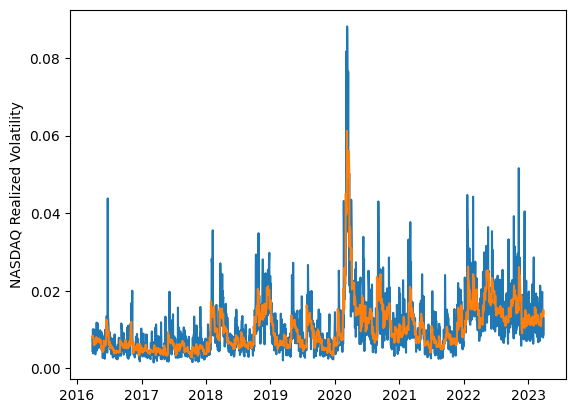

In [ ]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("NASDAQ Realized Volatility")

# H=10 Forecasts

In [ ]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]

In [ ]:
test_length=1750

In [ ]:
model = NBEATSx(h=10, input_size=21,
                loss=MQLoss(level=[90]),
                scaler_type='minmax',
                learning_rate= 0.0001,
                stack_types=['identity','identity'],
                n_blocks=[1,1],
                mlp_units= [[512, 512], [512, 512]],
                windows_batch_size=60,
                num_lr_decays=5,
                val_check_steps=100,
                n_harmonics=0, n_polynomials=0,
                hist_exog_list=['VIX'],
                max_steps=200,
                early_stop_patience_steps=1,
                random_seed=randrange(129228148)
                )
fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
forecasts = fcst.cross_validation(df=df,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=test_length,step_size=10)
forecasts = forecasts.dropna()
if "NBEATSx-median" not in list(forecasts.columns.values):
  Y_hat=forecasts["NBEATSx"].values
else:
  Y_hat=forecasts["NBEATSx-median"].values
Y_true=forecasts["y"].values
RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 121882687


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
RMSE

[0.0037949477347988853,
 0.003779501836655885,
 0.0037879664206704345,
 0.003723965595944434,
 0.0037129086018478506,
 0.003796280926903038,
 0.0037502333563395602,
 0.0037792056498714604,
 0.0037777394765443916,
 0.0037383426978469295,
 0.0036779128950747433,
 0.0037826329661882017,
 0.0037056671172825944,
 0.0037680338509862876,
 0.003801570279599897]

In [ ]:
Accuracy

[63.10846986854801,
 62.214861788896094,
 62.00460857529655,
 62.39119272066904,
 62.61493223431267,
 62.57564121575301,
 62.66218704725943,
 61.928624623539164,
 62.129338010251864,
 63.17472141855034,
 63.509790953778065,
 62.35095444885851,
 62.89196016232601,
 62.49561989597571,
 61.98378065348462]

In [ ]:
Quasilikelihood

[0.1177516547322299,
 0.11048514096331861,
 0.11220570254133469,
 0.10632851901240575,
 0.10544621274960664,
 0.11773175192257083,
 0.11076584119383967,
 0.10906741126084517,
 0.10973856055808749,
 0.10930624936654812,
 0.10499635798334829,
 0.11353193919582473,
 0.10580611014495445,
 0.11022512734307775,
 0.11000135994059526]

Text(0, 0.5, 'NASDAQ Realized Volatility')

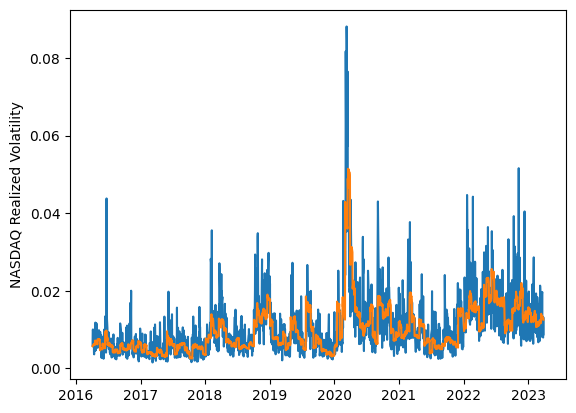

In [ ]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("NASDAQ Realized Volatility")

# H=22 Forecasts

In [ ]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]

In [ ]:
test_length=1738

In [ ]:
model = NBEATSx(h=22, input_size=21,
                loss=MQLoss(level=[90]),
                scaler_type='minmax',
                learning_rate= 0.0001,
                stack_types=['identity','identity'],
                n_blocks=[1,1],
                mlp_units= [[512, 512], [512, 512]],
                windows_batch_size=60,
                num_lr_decays=5,
                val_check_steps=100,
                n_harmonics=0, n_polynomials=0,
                hist_exog_list=['VIX'],
                max_steps=200,
                early_stop_patience_steps=1,
                random_seed=randrange(129228148)
                )
fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
forecasts = fcst.cross_validation(df=df,val_size=22,static_df=AirPassengersStatic,n_windows=None, test_size=test_length,step_size=22)
forecasts = forecasts.dropna()
if "NBEATSx-median" not in list(forecasts.columns.values):
  Y_hat=forecasts["NBEATSx"].values
else:
  Y_hat=forecasts["NBEATSx-median"].values
Y_true=forecasts["y"].values
RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 98229984


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
RMSE

[0.004150981565018263,
 0.00415282651788889,
 0.0040674243962103614,
 0.004083463366711053,
 0.004146016315550093,
 0.004097198351836951,
 0.004069404705118065,
 0.00410554106263361,
 0.004121391889698162,
 0.004125579853430213,
 0.0040691086994052,
 0.004099068301146499,
 0.004111932797401315,
 0.00405113082661853,
 0.004079122862150152]

In [ ]:
Accuracy

[57.861710649129094,
 57.67544485351881,
 58.74163984518579,
 58.54959526361624,
 57.2626671946319,
 58.80899699707043,
 58.95693524862031,
 58.057821849117545,
 57.908211201280736,
 58.36473360864123,
 58.575876885505366,
 58.85260889360768,
 58.61672235574736,
 59.17403528427807,
 58.89895159801859]

In [ ]:
Quasilikelihood

[0.15015602559085445,
 0.14713895553481565,
 0.1443641883232977,
 0.14763092951572515,
 0.14397388169003675,
 0.14688681770939022,
 0.1477982979147985,
 0.14540723553506105,
 0.14475636305702003,
 0.14999967467380446,
 0.14285038282855356,
 0.1500189304750792,
 0.1528129589207629,
 0.14381273461791472,
 0.1494122855594818]

Text(0, 0.5, 'NASDAQ Realized Volatility')

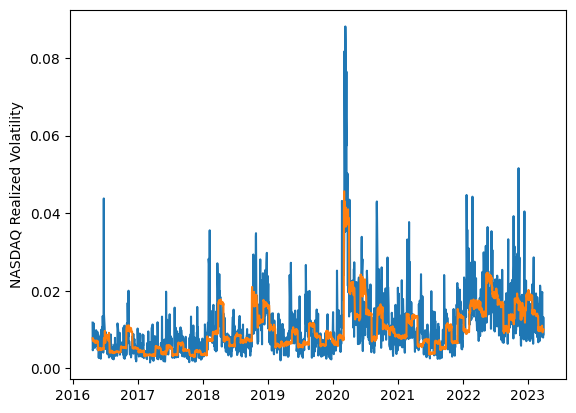

In [ ]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("NASDAQ Realized Volatility")